In [3]:
import os
import glob
import numpy as np
import pyvista as pv
import xarray as xr

# -------------------------------
# 1. Path to your VTK folder
# -------------------------------
vtk_base = "outputs/openfoam_cases/0000/VTK"

# Find all time-step folders containing internal.vtu
vtu_files = sorted(glob.glob(os.path.join(vtk_base, "0000_*", "internal.vtu")))

if not vtu_files:
    raise FileNotFoundError(f"No internal.vtu files found in {vtk_base}")

print(f"Found {len(vtu_files)} time steps.")

# -------------------------------
# 2. Initialize lists to store data
# -------------------------------
times = []
U_list, alpha_list, p_list = [], [], []

# -------------------------------
# 3. Loop over each VTU file
# -------------------------------
for f in vtu_files:
    mesh = pv.read(f)
    
    # Use cell_data (OpenFOAM usually exports as cell_data)
    cell_data = mesh.cell_data
    
    # Check field names
    if 'U' not in cell_data or 'alpha.water' not in cell_data or 'p_rgh' not in cell_data:
        print(f"Skipping {f}: missing one of the required fields")
        continue
    
    U_list.append(cell_data['U'])                # (ncells, 3)
    alpha_list.append(cell_data['alpha.water'])  # (ncells,)
    p_list.append(cell_data['p_rgh'])            # (ncells,)
    
    # Extract time from folder name (fallback if parsing fails)
    folder_name = os.path.basename(os.path.dirname(f))
    try:
        # Example: "0000_104162" -> 104162
        t = float(folder_name.split("_")[-1])
    except:
        t = len(times)
    times.append(t)

# -------------------------------
# 4. Convert to numpy arrays
# -------------------------------
U_arr = np.array(U_list)        # shape: (ntimes, ncells, 3)
alpha_arr = np.array(alpha_list)  # shape: (ntimes, ncells)
p_arr = np.array(p_list)          # shape: (ntimes, ncells)

ncells = U_arr.shape[1]

print(f"Collected data for {len(times)} time steps and {ncells} cells.")

# -------------------------------
# 5. Create xarray Dataset
# -------------------------------
ds = xr.Dataset(
    {
        'U': (('time', 'cell', 'component'), U_arr),
        'alpha_water': (('time', 'cell'), alpha_arr),
        'p_rgh': (('time', 'cell'), p_arr)
    },
    coords={
        'time': times,
        'cell': np.arange(ncells),
        'component': ['x', 'y', 'z']
    }
)

# -------------------------------
# 6. Save as NetCDF
# -------------------------------
output_file = os.path.join(vtk_base, "HyCFD_results.nc")
ds.to_netcdf(output_file)
print(f"Saved NetCDF file: {output_file}")


Found 11 time steps.
Collected data for 11 time steps and 114144 cells.
Saved NetCDF file: outputs/openfoam_cases/0000/VTK/HyCFD_results.nc


In [7]:
ds.isel(time=0)

<xarray.Dataset> Size: 3MB
Dimensions:      (cell: 114144, component: 3)
Coordinates:
  * cell         (cell) int64 913kB 0 1 2 3 4 ... 114140 114141 114142 114143
  * component    (component) <U1 12B 'x' 'y' 'z'
    time         float64 8B 0.0
Data variables:
    U            (cell, component) float32 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    alpha_water  (cell) float32 457kB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    p_rgh        (cell) float32 457kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [10]:
import pyvista as pv

mesh = pv.read("/Users/pabloalonsoalguacil/Documents/Proyectos/HyCFD/outputs/openfoam_cases/0000/VTK/0000_0/internal.vtu")

# Cell centers (coordinates)
cell_centers = mesh.cell_centers().points   # shape: (Ncells, 3)
print(cell_centers.shape)  # (114144, 3)


(114144, 3)


In [15]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

# Read mesh
mesh = pv.read("outputs/openfoam_cases/0000/VTK/0000_0/internal.vtu")

# Cell centers
cell_centers = mesh.cell_centers().points  # shape: (Ncells, 3)
x = cell_centers[:,0]
y = cell_centers[:,1]

# Fields (use cell_data)
alpha = mesh.cell_data['alpha.water']      # shape: (Ncells,)
U = mesh.cell_data['U']                    # shape: (Ncells, 3)
U_mag = np.linalg.norm(U, axis=1)         # velocity magnitude


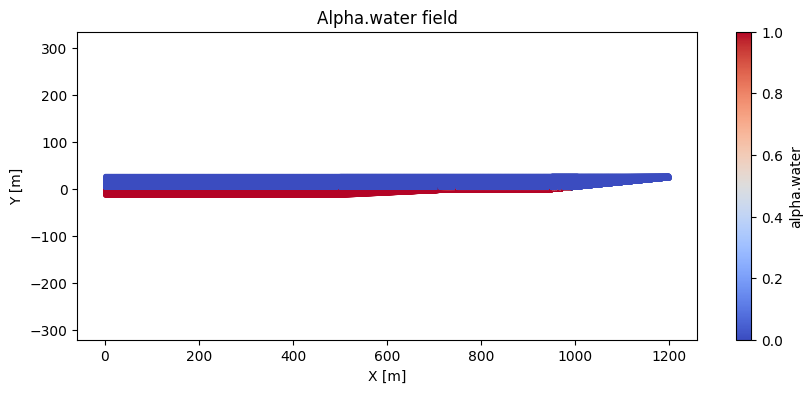

In [22]:
plt.figure(figsize=(10,4))
plt.scatter(x, y, c=alpha, cmap='coolwarm', s=5)  # s = marker size
plt.colorbar(label='alpha.water')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Alpha.water field')
plt.axis('equal')
plt.show()


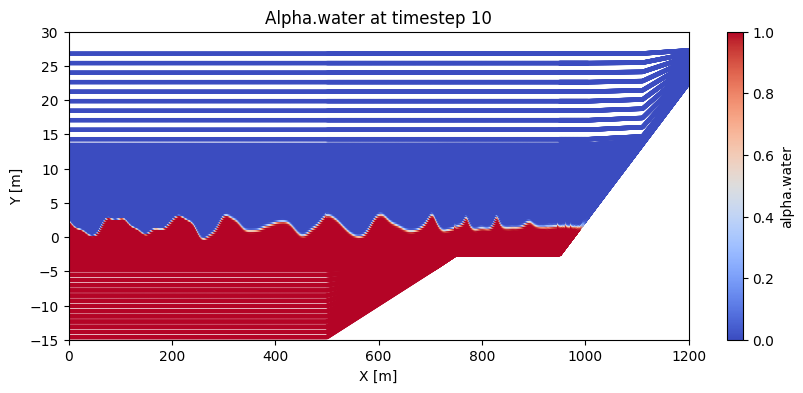

In [26]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import glob
import os

# Files
vtk_base = "outputs/openfoam_cases/0000/VTK"
vtu_files = sorted(glob.glob(os.path.join(vtk_base, "0000_*", "internal.vtu")))

# Mesh for cell centers
mesh0 = pv.read(vtu_files[0])
cell_centers = mesh0.cell_centers().points
x = cell_centers[:,0]
y = cell_centers[:,1]

# Figure
fig, ax = plt.subplots(figsize=(10,4))
scat = ax.scatter(x, y, c=np.zeros_like(x), cmap='coolwarm', s=5, vmin=0, vmax=1)
cbar = plt.colorbar(scat, ax=ax)
cbar.set_label('alpha.water')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Alpha.water evolution')
ax.set_xlim(0, 1200)   # domain X limits
ax.set_ylim(-15, 30)   # domain Y limits

# Update function
def update(frame):
    mesh = pv.read(vtu_files[frame])
    alpha = mesh.cell_data['alpha.water']
    scat.set_array(alpha)
    ax.set_title(f"Alpha.water at timestep {frame}")
    return scat,

# Animate
anim = FuncAnimation(fig, update, frames=len(vtu_files), interval=200, blit=True)
anim.save(os.path.join(vtk_base, "alpha_water_evolution.gif"), writer=PillowWriter(fps=5))


In [30]:
import os
import glob
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation, PillowWriter

# -------------------------------
# 1. Paths and files
# -------------------------------
vtk_base = "outputs/openfoam_cases/0000/VTK"
vtu_files = sorted(glob.glob(os.path.join(vtk_base, "0000_*", "internal.vtu")))

if not vtu_files:
    raise FileNotFoundError("No internal.vtu files found!")

print(f"Found {len(vtu_files)} time steps")

# -------------------------------
# 2. Read first mesh to get cell centers
# -------------------------------
mesh0 = pv.read(vtu_files[0])
cell_centers = mesh0.cell_centers().points
x = cell_centers[:,0]
y = cell_centers[:,1]

# -------------------------------
# 3. Create regular grid for interpolation
# -------------------------------
xi = np.linspace(np.min(x), np.max(x), 500)  # adjust resolution if needed
yi = np.linspace(np.min(y), np.max(y), 200)
XI, YI = np.meshgrid(xi, yi)

# -------------------------------
# Helper function to animate a scalar field
# -------------------------------
def animate_field(field_name, cmap='viridis', vmin=None, vmax=None, output_name=None,
                  xlim=None, ylim=None):
    fig, ax = plt.subplots(figsize=(10,4))
    im = ax.imshow(np.zeros_like(XI), extent=[xi[0], xi[-1], yi[0], yi[-1]],
                   origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, aspect='equal')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(field_name)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title(f"{field_name} evolution")
    
    # Apply fixed axes if provided
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    def update(frame):
        mesh = pv.read(vtu_files[frame])
        if field_name == 'U_mag':
            U = mesh.cell_data['U']
            data = np.linalg.norm(U, axis=1)
        else:
            data = mesh.cell_data[field_name]
        ZI = griddata((x, y), data, (XI, YI), method='linear')
        im.set_data(ZI)
        ax.set_title(f"{field_name} at timestep {frame}")
        return [im]
    
    anim = FuncAnimation(fig, update, frames=len(vtu_files), interval=200, blit=True)
    if output_name is None:
        output_name = f"{field_name}_evolution.gif"
    output_file = os.path.join(vtk_base, output_name)
    anim.save(output_file, writer=PillowWriter(fps=5))
    plt.close(fig)
    print(f"Saved animation: {output_file}")

# -------------------------------
# 4. Animate each field
# -------------------------------

# Example: set same X/Y limits as your domain
xlims = (0, 1200)
ylims = (-15, 30)

# alpha.water
animate_field('alpha.water', cmap='coolwarm', vmin=0, vmax=1,
              output_name='alpha_water_evolution.gif', xlim=xlims, ylim=ylims)

# p_rgh
p_min = -4e5
p_max = 5e5
animate_field('p_rgh', cmap='viridis', vmin=p_min, vmax=p_max,
              output_name='p_rgh_evolution.gif', xlim=xlims, ylim=ylims)

# velocity magnitude
U_max = 10
animate_field('U_mag', cmap='plasma', vmin=0, vmax=U_max,
              output_name='U_mag_evolution.gif', xlim=xlims, ylim=ylims)


Found 11 time steps
Saved animation: outputs/openfoam_cases/0000/VTK/alpha_water_evolution.gif
Saved animation: outputs/openfoam_cases/0000/VTK/p_rgh_evolution.gif
Saved animation: outputs/openfoam_cases/0000/VTK/U_mag_evolution.gif


In [32]:
import os
import glob
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation, PillowWriter

# -------------------------------
# 1. Paths and files
# -------------------------------
vtk_base = "outputs/openfoam_cases/0000/VTK"
vtu_files = sorted(glob.glob(os.path.join(vtk_base, "0000_*", "internal.vtu")))

if not vtu_files:
    raise FileNotFoundError("No internal.vtu files found!")

print(f"Found {len(vtu_files)} time steps")

# -------------------------------
# 2. Read first mesh to get cell centers
# -------------------------------
mesh0 = pv.read(vtu_files[0])
cell_centers = mesh0.cell_centers().points
x = cell_centers[:,0]
y = cell_centers[:,1]

# -------------------------------
# 3. Create regular grid for interpolation
# -------------------------------
# Define fixed domain limits for consistent axes
x_min, x_max = 0, 1200
y_min, y_max = -15, 30
xi = np.linspace(x_min, x_max, 500)
yi = np.linspace(y_min, y_max, 200)
XI, YI = np.meshgrid(xi, yi)

# -------------------------------
# Helper function to animate a scalar field
# -------------------------------
def animate_field(field_name, cmap='viridis', vmin=None, vmax=None, output_name=None):
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Initialize image with zeros using fixed extent
    im = ax.imshow(np.zeros_like(XI), 
                   extent=[x_min, x_max, y_min, y_max],  # <-- fixed axes
                   origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(field_name)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title(f"{field_name} evolution")
    
    def update(frame):
        mesh = pv.read(vtu_files[frame])
        if field_name == 'U_mag':
            U = mesh.cell_data['U']
            data = np.linalg.norm(U, axis=1)
        else:
            data = mesh.cell_data[field_name]
        # Interpolate to fixed grid
        ZI = griddata((x, y), data, (XI, YI), method='linear')
        im.set_data(ZI)
        ax.set_title(f"{field_name} at timestep {frame}")
        return [im]
    
    anim = FuncAnimation(fig, update, frames=len(vtu_files), interval=200, blit=True)
    
    if output_name is None:
        output_name = f"{field_name}_evolution.gif"
    output_file = os.path.join(vtk_base, output_name)
    anim.save(output_file, writer=PillowWriter(fps=5))
    plt.close(fig)
    print(f"Saved animation: {output_file}")

# -------------------------------
# 4. Animate each field
# -------------------------------
# alpha.water
animate_field('alpha.water', cmap='coolwarm', vmin=0, vmax=1, output_name='alpha_water_evolution.gif')

# p_rgh
animate_field('p_rgh', cmap='viridis', vmin=-4e5, vmax=5e5, output_name='p_rgh_evolution.gif')

# velocity magnitude
animate_field('U_mag', cmap='plasma', vmin=0, vmax=10, output_name='U_mag_evolution.gif')


Found 11 time steps
Saved animation: outputs/openfoam_cases/0000/VTK/alpha_water_evolution.gif
Saved animation: outputs/openfoam_cases/0000/VTK/p_rgh_evolution.gif
Saved animation: outputs/openfoam_cases/0000/VTK/U_mag_evolution.gif


In [34]:
import os
import glob
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation, PillowWriter

# -------------------------------
# 1. Paths and files
# -------------------------------
vtk_base = "outputs/openfoam_cases/0000/VTK"
vtu_files = sorted(glob.glob(os.path.join(vtk_base, "0000_*", "internal.vtu")))
if not vtu_files:
    raise FileNotFoundError("No internal.vtu files found!")
print(f"Found {len(vtu_files)} time steps")

# -------------------------------
# 2. Read first mesh to get cell centers
# -------------------------------
mesh0 = pv.read(vtu_files[0])
cell_centers = mesh0.cell_centers().points
x = cell_centers[:,0]
y = cell_centers[:,1]

# -------------------------------
# 3. Create regular grid for interpolation
# -------------------------------
x_min, x_max = 0, 1200
y_min, y_max = -15, 30
xi = np.linspace(x_min, x_max, 500)
yi = np.linspace(y_min, y_max, 200)
XI, YI = np.meshgrid(xi, yi)

# -------------------------------
# 4. Helper function using pcolormesh
# -------------------------------
def animate_field(field_name, cmap='viridis', vmin=None, vmax=None, output_name=None):
    fig, ax = plt.subplots(figsize=(12,4))  # wider figure for stretched domain

    # initialize a dummy plot
    ZI = np.zeros_like(XI)
    mesh_plot = ax.pcolormesh(XI, YI, ZI, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    cbar = plt.colorbar(mesh_plot, ax=ax)
    cbar.set_label(field_name)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title(f"{field_name} evolution")

    def update(frame):
        mesh = pv.read(vtu_files[frame])
        if field_name == 'U_mag':
            U = mesh.cell_data['U']
            data = np.linalg.norm(U, axis=1)
        else:
            data = mesh.cell_data[field_name]
        ZI = griddata((x, y), data, (XI, YI), method='linear')
        mesh_plot.set_array(ZI.ravel())  # pcolormesh expects 1D array
        ax.set_title(f"{field_name} at timestep {frame}")
        return [mesh_plot]

    anim = FuncAnimation(fig, update, frames=len(vtu_files), interval=200, blit=True)
    if output_name is None:
        output_name = f"{field_name}_evolution.gif"
    output_file = os.path.join(vtk_base, output_name)
    anim.save(output_file, writer=PillowWriter(fps=5))
    plt.close(fig)
    print(f"Saved animation: {output_file}")

# -------------------------------
# 5. Animate all fields
# -------------------------------
animate_field('alpha.water', cmap='coolwarm', vmin=0, vmax=1, output_name='alpha_water_evolution.gif')
animate_field('p_rgh', cmap='viridis', vmin=-4e5, vmax=5e5, output_name='p_rgh_evolution.gif')
animate_field('U_mag', cmap='plasma', vmin=0, vmax=10, output_name='U_mag_evolution.gif')


Found 11 time steps
Saved animation: outputs/openfoam_cases/0000/VTK/alpha_water_evolution.gif
Saved animation: outputs/openfoam_cases/0000/VTK/p_rgh_evolution.gif
Saved animation: outputs/openfoam_cases/0000/VTK/U_mag_evolution.gif
